In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

# Func

In [119]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [133]:
def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10):
    df_th = df.copy()
    # df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

# Load

In [147]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # subtract baseline???
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']


   mouse           date area  num
0   1350  211222_caiman   V1  2.0


# split side A/B bootstrap

In [112]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]
dfof_ad_sideA = np.empty((ncell, nstim))
dfof_ad_sideB = np.empty((ncell, nstim))
dfof_tg_sideA = np.empty((ncell, nstim))
dfof_tg_sideB = np.empty((ncell, nstim))

for icell in np.arange(ncell):
    for istim in np.arange(nstim):
        ntrial_cond = dfof_ad_trial[icell,istim].shape[0]

        idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
        dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
        dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

        idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
        dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
        dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7)
adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)

In [158]:
_, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
_, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

corr_pearson_pop = []
p_pearson_pop = []
corr_spearman_pop = []
nstim_shared = []

for icell in np.arange(ncell):
    df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
    df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
    _, mag_mean_sideA_cell, _, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0.00025, adp_threshold=10)
    _, mag_mean_sideB_cell, _, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0.00025, adp_threshold=10)

    not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
    nstim_shared.append(sum(not_nan_mask))

    corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
    corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only probably reasonable for datasets larger than 500 or so
    # print(icell, corr_pearson_cell, p_pearson_cell, corr_spearman_cell)

    corr_pearson_pop.append(corr_pearson_cell)
    p_pearson_pop.append(p_pearson_cell)
    corr_spearman_pop.append(corr_spearman_cell)
    
# print(nstim_shared)#, corr_pearson_pop, p_pearson_pop, corr_spearman_pop)

[25, 25, 26, 25, 27, 26, 24, 29, 29, 28, 25, 25, 26, 25, 24, 28, 23, 26, 26, 26, 24, 27, 30, 30, 25, 26, 24, 23, 28, 25, 30, 25, 25, 26, 26, 28, 27, 25, 24, 28, 27, 27, 25, 26, 24, 25, 27, 22, 26, 25, 28, 29, 27, 27, 28, 25, 27, 29, 29, 26, 28, 26, 27, 27, 28, 26, 23, 22, 27, 29, 22, 28, 26, 23, 28, 27, 28, 27, 27, 29, 25, 28, 26, 27, 27, 25, 27, 29, 29, 24, 28, 26, 25, 24, 29, 27, 27, 26, 26, 26, 25, 25, 25, 27, 29, 27, 26, 27, 28, 24, 28, 27, 30, 26, 26, 27, 28, 23, 27, 26, 30, 24, 26, 27, 27, 24, 25, 25, 25, 26, 27, 26, 26, 27, 27, 29, 27, 26, 20, 27, 27, 28, 22, 28, 26, 25, 26, 24, 28, 23, 27, 27, 26, 26, 26, 25, 27, 27, 26, 28, 25, 26, 26, 24, 25, 25, 29, 24, 28, 27, 24, 27, 28, 26, 24, 27, 28, 28, 25, 25, 22, 28, 28, 26, 26, 26, 25, 29, 28, 28, 25, 25, 26, 27, 27, 27, 26, 25, 30, 26, 25, 27, 25, 27, 27, 26, 27, 29, 24, 26, 28, 25, 26, 28, 24, 23, 26, 29, 22, 25, 23, 28, 29, 24, 26, 28, 25, 27, 26, 26, 23, 26, 25, 29, 24, 24, 24, 26, 25, 29, 27, 23, 26, 25, 24, 28, 24, 26, 27, 27,

In [167]:
sum(np.array(p_pearson_pop) < 0.05) / len(p_pearson_pop)

0.06649616368286446

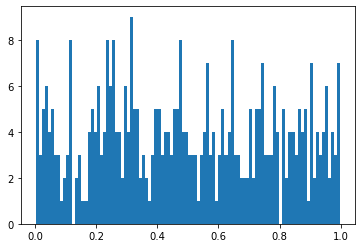

In [165]:
plt.hist(p_pearson_pop, 100);